# 04 – Preprocessing & Feature Engineering
### Car Price Prediction Using Machine Learning
Group Assignment 02 - CCS3012 - Data Analytics  
Submission Date: 16th September 2025

---

### **Group 11**
-  **FC211034 - N.D. Samararathne Kodikara**
-  **FC211013 - N.W.V. Tharindu Pabasara**
-  **FC211025 - W.M.M.C.B. Wijesundara**



---


### **Supervisor**
**Ms. Dilmi Praveena**  
*Faculty of Computing*  
*University of Sri Jayewardenepura*

---


## 📌 Objectives

This notebook builds upon the cleaned dataset produced in **Notebook 01 — Data Exploration & Cleaning**.
The focus here is to prepare the dataset for modeling by performing outlier handling, feature engineering, and deterministic cleaning.

---

- **Outlier detection & handling**: Identify extreme or unrealistic values in numeric features (`price`, `mileage`, `levy`, `engine_volume`).

- **Feature engineering & derived columns**: Create new features that better capture the characteristics of the cars with the use of insights gained from **Notebook 02 — Descriptive Analytics and EDA**

- **Categorical mapping & rare category handling**: Group rare categories as "other" to reduce noise and high cardinality.

- **Prepare train/test datasets for modeling**: Split into training and testing sets. Save processed datasets and mappings for **Notebook 04 — Modeling & Evaluation**.


---

### 📂 Input  
- `clean_data.csv` saved in `Data/processed/`  

### 📦 Output  

- `X_train.pkl, X_test.pkl` saved in `Data/processed/`

- `y_train_log.pkl, y_test_log.pkl` log-transformed target for scale-sensitive models (Linear, KNN, SVR)

- `y_train_cap.pkl, y_test_cap.pkl` capped target for tree-based models (RandomForest, Gradient Boosting)


---

### 📊 Dataset Overview
**Dataset:** Car price dataset cleaned.  
**columns include**:   
- `id`, `price` (target variable),  `levy`,  `manufacturer`,  `model`,  `prod_year`,  `category`,  `leather_interior`,  `fuel_type`, `engine_volume`,  `mileage`,  `cylinders`,  `gear_box_type`,  `drive_wheels`,  `doors`,  `wheel`, `color`,  `airbags`,  `turbo` (derived in Notebook 01)


> **Dataset stats:** 19,237 rows × 19 features | Target variable: `price` | Problem type: Regression


# Setup & imports

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns


# Statistical functions
from scipy import stats
import joblib
import pickle

from sklearn.model_selection import train_test_split

from prettytable import PrettyTable 

In [2]:
df = pd.read_csv("./Data/processed/clean_data.csv")


In [3]:
# Function to normalize text
def normalize_text(s):
    if pd.isna(s):
        return s
    s = str(s).strip().lower()        # lowercase and strip spaces
    s = s.replace(' ', '-')           # replace spaces with '-'
    return s

# Apply to all object columns
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].apply(normalize_text)

# Quick check
df.head()

,id,price,levy,manufacturer,model,prod_year,category,leather_interior,fuel_type,engine_volume,mileage,cylinders,gear_box_type,drive_wheels,doors,wheel,color,airbags,turbo
0,45654403,13328,1399.0,lexus,rx-450,2010,jeep,yes,hybrid,3.5,186005,6,automatic,4x4,04-may,left-wheel,silver,12,False
1,44731507,16621,1018.0,chevrolet,equinox,2011,jeep,no,petrol,3.0,192000,6,tiptronic,4x4,04-may,left-wheel,black,8,False
2,45774419,8467,0.0,honda,fit,2006,hatchback,no,petrol,1.3,200000,4,variator,front,04-may,right-hand-drive,black,2,False
3,45769185,3607,862.0,ford,escape,2011,jeep,yes,hybrid,2.5,168966,4,automatic,4x4,04-may,left-wheel,white,0,False
4,45809263,11726,446.0,honda,fit,2014,hatchback,yes,petrol,1.3,91901,4,automatic,front,04-may,left-wheel,silver,4,False


In [4]:
# Prints the name of each column in the dataset, the number of non-null values it contains, and its data type.
def df_info(df):
    table = PrettyTable()
    table.field_names = ["Column", "Non-Null Count", "Dtype"]

    for col in df.columns:
        non_null_count = df[col].count()
        dtype = df[col].dtype
        table.add_row([col, non_null_count, dtype])

    print(table)

df_info(df)

+------------------+----------------+---------+
|      Column      | Non-Null Count |  Dtype  |
+------------------+----------------+---------+
|        id        |     15697      |  int64  |
|      price       |     15697      |  int64  |
|       levy       |     15697      | float64 |
|   manufacturer   |     15697      |  object |
|      model       |     15697      |  object |
|    prod_year     |     15697      |  int64  |
|     category     |     15697      |  object |
| leather_interior |     15697      |  object |
|    fuel_type     |     15697      |  object |
|  engine_volume   |     15697      | float64 |
|     mileage      |     15697      |  int64  |
|    cylinders     |     15697      |  int64  |
|  gear_box_type   |     15697      |  object |
|   drive_wheels   |     15697      |  object |
|      doors       |     15697      |  object |
|      wheel       |     15697      |  object |
|      color       |     15697      |  object |
|     airbags      |     15697      |  i

💡 **Observations:**  
- The data set appears unchanged and matches the previously saved version.

Le't start...

# **Deterministic cleaning & derive columns**

## `doors` column

> 🧩 Standardize to two representations:
> - `doors_count` numeric: 2, 4, 6 (use 6 as proxy for >5)
> - `doors_cat` original categorical for interactions

In [5]:
def doors_to_count(s):
    if pd.isna(s): return np.nan
    s = str(s).lower()
    if '02' in s or '02-mar' in s: return 2
    if '04' in s or '04-may' in s: return 4
    if '>' in s or '>5' in s: return 6
    # fallback: try to extract first number
    import re
    m = re.search(r'\d+', s)  # fallback: extract first number in the string
    return int(m.group()) if m else np.nan

df['doors_count'] = df['doors'].apply(doors_to_count)
print(f"✅ created doors_count column.")
df['doors_count'].value_counts()


✅ created doors_count column.


doors_count
4    14835
2      738
6      124
Name: count, dtype: int64

In [6]:
# Mapping dictionary
doors_map = {
    '02-mar': '2-3',
    '04-may': '4-5',
    '>5': '>5'
}

# Apply mapping
df['doors_cat'] = df['doors'].map(doors_map).fillna(df['doors'])
print(f"✅ created doors_cat column.")
df['doors_cat'].value_counts()

✅ created doors_cat column.


doors_cat
4-5    14835
2-3      738
>5       124
Name: count, dtype: int64

## `Cylinders` column

> 🧩 grouping into buckets  
> 🧩 Ordinal encoding. start with `1`


In [7]:
def cylinder_group(x):
    if pd.isna(x): return np.nan
    if x <= 2: return '1-2'
    if 3 <= x <= 4: return '3-4'
    if 5 <= x <= 8: return '5-8'
    return '>8'

df['cylinder_group'] = df['cylinders'].apply(cylinder_group)
print(f"✅ created cylinder_group column.")
df['cylinder_group'].value_counts()


✅ created cylinder_group column.


cylinder_group
3-4    12372
5-8     3196
1-2       78
>8        51
Name: count, dtype: int64

In [8]:
# Define the order
cylinder_order = ['1-2', '3-4', '5-8', '>8']

# Map to ordinal numbers
df['cylinder_group_ord'] = df['cylinder_group'].map({k: i+1 for i, k in enumerate(cylinder_order)})

print(f"✅ created cylinder_group_ord column.\n")
print(df[['cylinder_group', 'cylinder_group_ord']].head())


✅ created cylinder_group_ord column.

  cylinder_group  cylinder_group_ord
0            5-8                   3
1            5-8                   3
2            3-4                   2
3            3-4                   2
4            3-4                   2


## `Airbags` column

> 🧩 Grouping ['0','1-2','3-4','5-8','>8']  
> 🧩 Ordinal Encoding. start with `0`

In [9]:
# Function to group airbags
def airbags_group(n):
    if pd.isna(n):  # handle missing values
        return np.nan
    if n == 0:
        return '0'
    if 1 <= n <= 2:
        return '1-2'
    if 3 <= n <= 4:
        return '3-4'
    if 5 <= n <= 8:
        return '5-8'
    return '>8'

# Apply to datset
df['airbags_group'] = df['airbags'].apply(airbags_group)
print(f"✅ created airbags_group column.")
df['airbags_group'].value_counts()


✅ created airbags_group column.


airbags_group
3-4    5141
>8     5019
5-8    3040
0      1378
1-2    1119
Name: count, dtype: int64

In [10]:
airbags_order = ['0', '1-2', '3-4', '5-8', '>8']  # define order

# ordinal encoding
df['airbags_group_ord'] = df['airbags_group'].map({k: i for i, k in enumerate(airbags_order)})

print(f"✅ created airbags_group_ord column.\n")
print(df[['airbags_group', 'airbags_group_ord']].head())


✅ created airbags_group_ord column.

  airbags_group  airbags_group_ord
0            >8                  4
1           5-8                  3
2           1-2                  1
3             0                  0
4           3-4                  2


## `Car Age` column

> 🧩 current_year - prod_year

In [11]:
import datetime

current_year = datetime.datetime.now().year  # get current year

df['car_age'] = current_year - df['prod_year']

print(f"✅ created car_age column.")
# check for negative or weird values
print(df['car_age'].describe())


✅ created car_age column.
count    15697.000000
mean        14.410015
std          5.697194
min          5.000000
25%         11.000000
50%         13.000000
75%         17.000000
max         45.000000
Name: car_age, dtype: float64


## `leather_interior` column

> 🧩 create `has_leather` binary : Directly captures the positive price effect of leather.

In [12]:
# Function map has_leather
def has_leather(x):
    if pd.isna(x):
        return 0 
    if str(x).strip().lower() in ['yes']:
        return 1
    return 0

# Apply to df
df['has_leather'] = df['leather_interior'].apply(has_leather)

print(f"✅ created has_leather column.\n")

# Quick check
print(df[['leather_interior', 'has_leather']].value_counts())


✅ created has_leather column.

leather_interior  has_leather
yes               1              10547
no                0               5150
Name: count, dtype: int64


## `color` column

> 🧩 create feature `is_common_color` : [black/white/silver/grey/blue/red]  


In [13]:
# Define common colors
common_colors = ['black', 'white', 'silver', 'grey', 'blue', 'red']

# Function to check if color is common
def is_common_color_func(color):
    if pd.isna(color):
        return 0
    return 1 if str(color).strip().lower() in common_colors else 0

# Apply to df
df['is_common_color'] = df['color'].apply(is_common_color_func)


print(f"✅ created is_common_color column.\n")

# Quick check
print(df[['color', 'is_common_color']].value_counts())


✅ created is_common_color column.

color          is_common_color
black          1                  3832
white          1                  3605
silver         1                  3146
grey           1                  1918
blue           1                  1245
red            1                   564
green          0                   286
orange         0                   204
carnelian-red  0                   177
brown          0                   171
golden         0                   142
beige          0                   132
sky-blue       0                   119
yellow         0                    92
purple         0                    39
pink           0                    25
Name: count, dtype: int64


## `category` column

> 🧩 Domain Mapping: map `categories` into `luxury`, `utility`, `family`.  
> 🧩 Create `category_simple` column.

In [14]:
# Normalize category strings: lowercase, replace spaces with dash, strip
df['category'] = df['category'].str.lower().str.strip().str.replace(' ', '-')


# define mappings
domain_map = {
    'sedan': 'family',
    'hatchback': 'family',
    'universal': 'family',
    'jeep': 'utility', 
    'pickup': 'utility',
    'goods-wagon': 'utility',
    'limousine': 'luxury',
    'cabriolet': 'luxury',
    'coupe': 'luxury',
    'minivan': 'family',
    'microbus': 'family'
}


# Apply mapping
df['domain'] = df['category'].str.strip().str.lower().map(domain_map)


print(f"✅ created domain column.\n")

# Quick check
print(df['domain'].value_counts())



✅ created domain column.

domain
family     10687
utility     4496
luxury       514
Name: count, dtype: int64


In [15]:
category_map = {
    # SUVs / off-road
    'jeep': 'suv',
    'suv': 'suv',
    'pickup': 'suv',
    'goods-wagon': 'suv',
    
    # cars
    'limousine': 'car',
    'cabriolet': 'car',
    'coupe': 'car',
    'sedan': 'car',
    'hatchback': 'car',
    'universal': 'car',
    
    # Family / vans
    'minivan': 'van',
    'microbus': 'van'
}

df['category_simple'] = df['category'].str.strip().str.lower().map(category_map)

print(f"✅ created category_simple column.\n")

# Quick check
print(df['category_simple'].value_counts())


✅ created category_simple column.

category_simple
car    10372
suv     4496
van      829
Name: count, dtype: int64


## `engine_volume` × `Turbo` columns

> 🧩 create `engine_turbo`column : `engine_volume` * `turbo_flag`

In [16]:
# Make sure these columns exist and are numeric
df['engine_volume'] = pd.to_numeric(df['engine_volume'], errors='coerce')


In [17]:
# Create the interaction feature
df['engine_turbo'] = df['engine_volume'] * df['turbo']

print(f"✅ created engine_turbo column.\n")

print(df[['engine_volume', 'turbo', 'engine_turbo']].tail())

✅ created engine_turbo column.

       engine_volume  turbo  engine_turbo
15692            1.8  False           0.0
15693            2.0   True           2.0
15694            2.4  False           0.0
15695            2.0  False           0.0
15696            2.4  False           0.0


## `doors_count` and `domain` columns

> 🧩 interactions between categorical variables `doors_count` and `domain`.

In [18]:
# create doors_domain feature
df['doors_domain'] = df['doors_count'].astype(str) + '_' + df['domain'].astype(str)

print(f"✅ created doors_domain column.\n")

# Quick check
print(df[['doors_count', 'domain', 'doors_domain']].value_counts().head(3))


✅ created doors_domain column.

doors_count  domain   doors_domain
4            family   4_family        10371
             utility  4_utility        4316
2            luxury   2_luxury          365
Name: count, dtype: int64


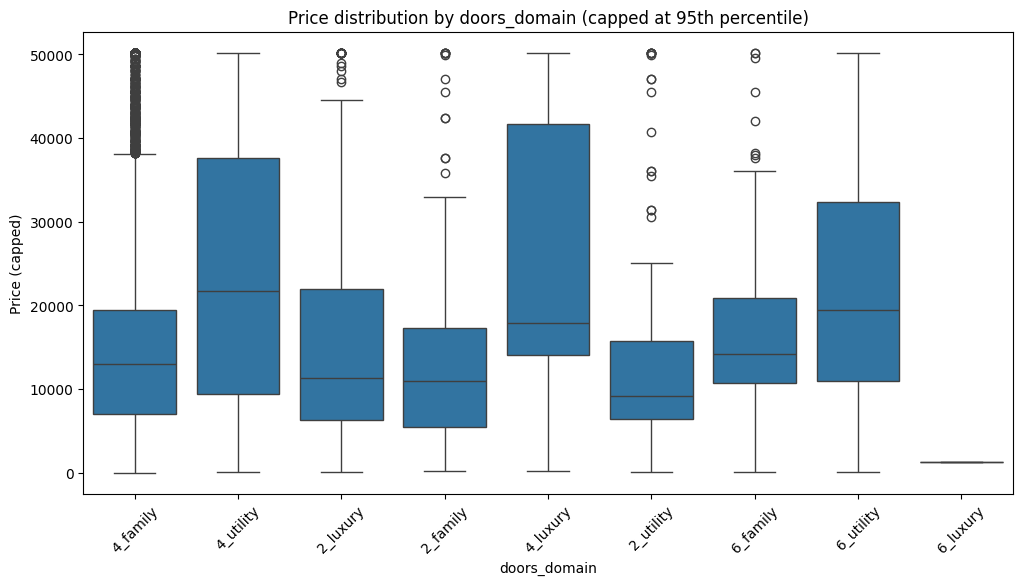

In [19]:
# plot (vs price)
price_cap = df['price'].quantile(0.95)
df['price_capped'] = df['price'].clip(upper=price_cap)

# Box plot with capped price
plt.figure(figsize=(12,6))
sns.boxplot(x='doors_domain', y='price_capped', data=df, order=df['doors_domain'].value_counts().index)
plt.title('Price distribution by doors_domain (capped at 95th percentile)')
plt.xlabel('doors_domain')
plt.ylabel('Price (capped)')
plt.xticks(rotation=45)
plt.show()

# **Outlier Detection & Handling**

              price  price_capped     price_log
count  1.569700e+04  15697.000000  15697.000000
mean   2.028445e+04  18184.009110      9.238175
std    2.108237e+05  16422.361246      1.419014
min    1.000000e+00     40.000000      3.713572
25%    7.527000e+03   7527.000000      8.926385
50%    1.426900e+04  14269.000000      9.565915
75%    2.338900e+04  23389.000000     10.060064
max    2.630750e+07  89379.000000     11.400652


<Figure size 1200x500 with 0 Axes>

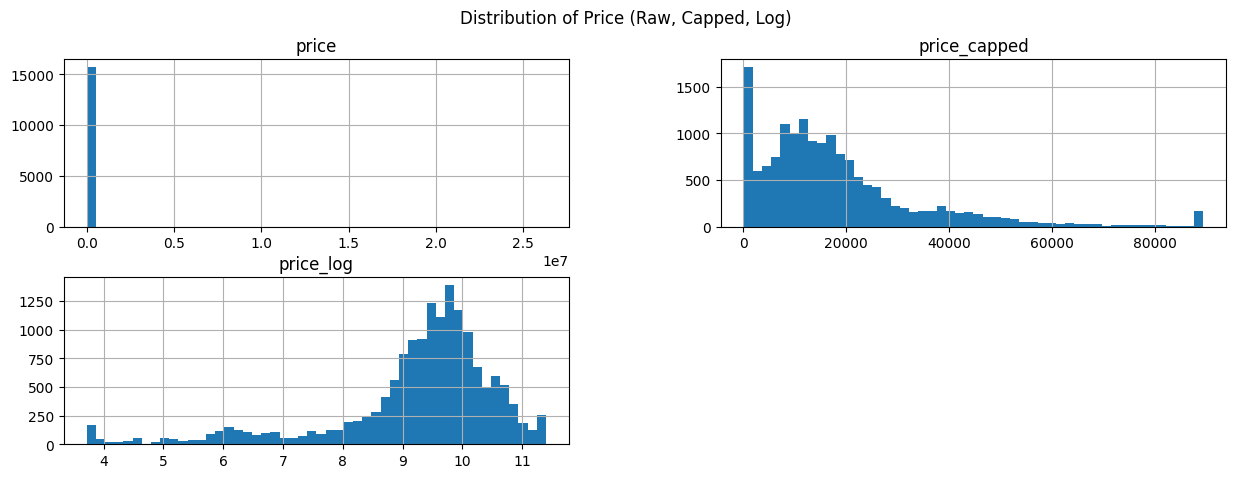

In [20]:
# Define numeric + target
numeric_cols = ['mileage', 'engine_volume', 'levy']
target_col = 'price'

# Outlier capping (1st and 99th percentiles)
for col in numeric_cols + [target_col]:
    lower = df[col].quantile(0.01)
    upper = df[col].quantile(0.99)
    df[col + '_capped'] = df[col].clip(lower, upper)

# Log-transform numeric columns (optional, useful for regression models)
for col in numeric_cols + [target_col]:
    df[col + '_log'] = np.log1p(df[col + '_capped'])

# Quick check
print(df[[target_col, target_col + '_capped', target_col + '_log']].describe())

# visualize price distributions
plt.figure(figsize=(12,5))
df[[target_col, target_col + '_capped', target_col + '_log']].hist(bins=50, figsize=(15,5))
plt.suptitle("Distribution of Price (Raw, Capped, Log)")
plt.show()


> 🧩 Define a threshold (e.g., median > 60k) to automatically detect luxury brands.  
> 🧩 Drop rows belonging to those manufacturers.

In [21]:
# Median price per manufacturer
brand_stats = df.groupby('manufacturer')['price_capped'].median().sort_values(ascending=False)

#  Detect luxury brands (median > 60k)
luxury_brands = brand_stats[brand_stats > 60000].index.tolist()
print("🔹 Luxury brands detected:", luxury_brands)

🔹 Luxury brands detected: ['bentley', 'lamborghini', 'ferrari']


In [22]:
# Remove luxury brands from dataset
before_shape = df.shape[0]

df = df[~df['manufacturer'].isin(luxury_brands)].copy()

after_shape = df.shape[0]
removed_rows = before_shape - after_shape

print(f"⛔ Removed {len(luxury_brands)} luxury brands ({removed_rows} rows). New shape: {df.shape}")


⛔ Removed 3 luxury brands (5 rows). New shape: (15692, 40)


# **Train/Test Split**

## Choose Target and Features



> 🧩 **Target** for linear/SVR/KNN: price_log → reduces skew.  
> 🧩 **Target** for tree-based models: price_capped → handles outliers naturally.
>
> 🧩 **Features**: all relevant columns except: 
> - Raw targets: `price`, `price_capped`, `price_log`.
> - `id`


⛔  **Drop Raw / replaced features that we have already derived cleaned versions from.**

In [23]:
print(df.columns.to_list())

['id', 'price', 'levy', 'manufacturer', 'model', 'prod_year', 'category', 'leather_interior', 'fuel_type', 'engine_volume', 'mileage', 'cylinders', 'gear_box_type', 'drive_wheels', 'doors', 'wheel', 'color', 'airbags', 'turbo', 'doors_count', 'doors_cat', 'cylinder_group', 'cylinder_group_ord', 'airbags_group', 'airbags_group_ord', 'car_age', 'has_leather', 'is_common_color', 'domain', 'category_simple', 'engine_turbo', 'doors_domain', 'price_capped', 'mileage_capped', 'engine_volume_capped', 'levy_capped', 'mileage_log', 'engine_volume_log', 'levy_log', 'price_log']


In [24]:
drop_cols = [
    'category', 'leather_interior', 'doors',
    'airbags', 'engine_volume', 'mileage', 'levy', 'prod_year'
]

df = df.drop(columns=drop_cols)

print(f"⛔ Dropped {len(drop_cols)} features.")


⛔ Dropped 8 features.


In [25]:
X = df.drop(columns=['id', 'price', 'price_capped', 'price_log'])
y_log = df['price_log']   # for linear/SVR/KNN
y_cap = df['price_capped'] # for tree-based


joblib.dump(X, 'Data/processed/X.pkl')

['Data/processed/X.pkl']

## Split the Dataset

> 🧩 Keep one consistent split for all models.  
> 🧩 Use category_simple for stratified splitting: small number of imbalanced classes.

In [26]:
X_train, X_test, y_train_log, y_test_log = train_test_split(
    X, y_log, test_size=0.2, random_state=42, stratify=df['category_simple']
)

# Tree-based target for same indices
y_train_cap = y_cap.loc[y_train_log.index]
y_test_cap = y_cap.loc[y_test_log.index]


# **Train-set-Only Feature Engineering**

## Manufacturer Grouping

> 🧩 Replace rare manufacturers with "other_manufacturer"

In [27]:
# keep top manufacturers by count (say top 10)
top_manufacturers = X_train['manufacturer'].value_counts().nlargest(10).index

X_train['manufacturer_grouped'] = X_train['manufacturer'].apply(
    lambda x: x if x in top_manufacturers else 'other'
)
X_test['manufacturer_grouped'] = X_test['manufacturer'].apply(
    lambda x: x if x in top_manufacturers else 'other'
)

print("✅ Created 'manufacturer_grouped' column in train and test sets.")



✅ Created 'manufacturer_grouped' column in train and test sets.


In [28]:
print("🔹 Grouped manufacturers of train set:")
print(X_train['manufacturer_grouped'].unique())
print("\n🔹 Grouped manufacturers of test set:")
print(X_test['manufacturer_grouped'].unique())


🔹 Grouped manufacturers of train set:
['other' 'toyota' 'chevrolet' 'ssangyong' 'hyundai' 'mercedes-benz' 'bmw'
 'nissan' 'honda' 'ford' 'volkswagen']

🔹 Grouped manufacturers of test set:
['hyundai' 'ford' 'mercedes-benz' 'nissan' 'other' 'chevrolet' 'ssangyong'
 'volkswagen' 'toyota' 'bmw' 'honda']


💡 **Observations:**  
- Both train and test sets has the same grouped manufacturers.

In [29]:
# Drop original manufacturer column
X_train = X_train.drop(columns=['manufacturer'])
X_test = X_test.drop(columns=['manufacturer'])

print("⛔ Dropped 'manufacturer' column.")


⛔ Dropped 'manufacturer' column.


## Model Handling

> 🧩 Encode as `model_median_price`: Compute median price per model. (using train only)  
> 🧩 Flag `is_top_luxury_model` (top 5% of medians)

### Compute median prices

In [30]:
# Use capped price for median computation
train_temp = X_train.copy()
train_temp['price_capped'] = y_train_cap  # ensure alignment

# Median price per model
model_medians = train_temp.groupby('model')['price_capped'].median().to_dict()

# Global median fallback (for unseen models in test)
global_median = y_train_cap.median()


### Flag top 5% luxury models

In [31]:
# Threshold for top 5% expensive models
luxury_threshold = np.percentile(list(model_medians.values()), 95)
luxury_models = {m for m, v in model_medians.items() if v >= luxury_threshold}


### Map features

In [32]:
# Apply to train
X_train['model_median_price'] = X_train['model'].map(model_medians).fillna(global_median)
X_train['is_top_luxury_model'] = X_train['model'].isin(luxury_models).astype(int)

# Apply to test
X_test['model_median_price'] = X_test['model'].map(model_medians).fillna(global_median)
X_test['is_top_luxury_model'] = X_test['model'].isin(luxury_models).astype(int)

print("✅ Created model_median_price and is_top_luxury_model columns.")


✅ Created model_median_price and is_top_luxury_model columns.


### inspect created features

#### Check for unseen models in test

In [33]:
test_unseen_models = set(X_test['model']) - set(X_train['model'])

print("🔹 Number of unseen models in test:", len(test_unseen_models))
print("🔹 Unseen models in test:", test_unseen_models)


🔹 Number of unseen models in test: 167
🔹 Unseen models in test: {'prius-v-alpina', 'golf-1.8', 'space-runner', 'tt', 'wrangler-sport', '2111', 'gla-200', 's6', 'viano-ambiente', 'b-180', 'primera', 'v-230', 'dart-limited', 'cc-2.0-t', 'rc-f-f-sport', 'rav-4-xle', 'combo-1700', 'versa-s', 'clk-320-amg', 'camaro-rs', 'prius-blug-in', 'skyline-4wd', 'cruze-l-t', 'prius-tss-limited', 'clk-55-amg', 'prius-3', 'c-240-w203', 'pathfinder-se', 'smart-fortwo', 'mazda-3-sport', 'almera-dci', '130', 'elantra-2016', 'fj-cruiser', 'passat-pasat', 'march-231212', '21-3.0', '325-xi', 'clk-280', 'passat-b5', 'crafter-2.5-tdi', 'elantra-2014', 's3', 'allante', 'mustang-cabrio', 'transit-350t', 'will-vs', 'g6', 'fit-aria', 'ecosport-se', 'sprinter-max', 'g-65-amg-63amg', 'e-280-3.0', '316-i', 'veracruz', 'camry-xv50', 'focus-fokusi', 'astra-td', 'pajero-montero', 'prius-plugin', 'rav-4-dizel', 'x-trail-nissan-x-trail-r', 'regal', 'prius-2014', 's-430-4.3', 'e-200-w210', 'aqua-g-soft-leather-sele', 'ml-35

💡 **Observations:**  
- Unseen models exist: This is exactly what we wanted to avoids data leakage and keeps predictions consistent. 

#### Spot check a known luxury model

In [34]:
luxury_check = X_train[X_train['model'].isin(luxury_models)]
luxury_check[['model', 'model_median_price', 'is_top_luxury_model']].head()


,model,model_median_price,is_top_luxury_model
313,a7-prestige,89379.0,1
8846,explorer,65024.0,1
8280,explorer,65024.0,1
9354,glc-300,71974.0,1
8101,amg-gt-s,89379.0,1


💡 **Observations:**  
- confirms that the model feature engineering worked as intended.
- Luxury flag is correct: models like a7-prestige, glc-300, amg-gt-s are all top luxury models.

### Drop original model  column

In [35]:
# Drop original model column
X_train = X_train.drop(columns=['model'])
X_test = X_test.drop(columns=['model'])

print("⛔ Dropped 'model' column.")


⛔ Dropped 'model' column.


## Other rare Category Handling

### Inspect categorical columns

In [36]:
# Identify categorical columns
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns

print("🔹 categorical columns and number of classes for each:\n")

# Print value counts for each categorical column
for col in categorical_cols:
    print(f"{col}: {X_train[col].nunique()} classes")


🔹 categorical columns and number of classes for each:

fuel_type: 6 classes
gear_box_type: 4 classes
drive_wheels: 3 classes
wheel: 2 classes
color: 16 classes
doors_cat: 3 classes
cylinder_group: 4 classes
airbags_group: 5 classes
domain: 3 classes
category_simple: 3 classes
doors_domain: 9 classes
manufacturer_grouped: 11 classes


> 🧩 *Low-cardinality features* (≤5 classes) → safe for one-hot encoding, no need for rare-category handling.  
> 🧩 *Medium-cardinality features* → check counts and map rare categories to "other" to reduce noise.  
> 🧩 Already handled features: color → `is_common_color`, `manufacturer_grouped` → top 10 + "other".

### `doors_domain` feature

> 🧩 Set a frequency threshold and replace rare categories with "other".

In [37]:
threshold = 10
counts = X_train['doors_domain'].value_counts()
rare_cats = counts[counts < threshold].index

# Replace in train
X_train['doors_domain'] = X_train['doors_domain'].replace(rare_cats, 'other')
# Replace in test using same rare categories
X_test['doors_domain'] = X_test['doors_domain'].replace(rare_cats, 'other')

# Check result
print("🔹 Value counts in `X_train`:")
print(X_train['doors_domain'].value_counts())
print("\n🔹 Value counts in `X_test`:")
print(X_test['doors_domain'].value_counts())


🔹 Value counts in `X_train`:
doors_domain
4_family     8284
4_utility    3463
2_luxury      291
2_family      200
4_luxury      120
2_utility     100
6_family       60
6_utility      34
other           1
Name: count, dtype: int64

🔹 Value counts in `X_test`:
doors_domain
4_family     2085
4_utility     853
2_luxury       71
2_family       37
2_utility      36
4_luxury       28
6_family       19
6_utility      10
Name: count, dtype: int64


### `color` feature

> 🧩 We already created `is_common_color` for the most frequent colors. Now we can map rare colors to "other".   
> 🧩 Rare colors (anything not in `common_colors`) become "other".

In [38]:
# Function to map rare colors
def map_color(color, common_colors): # common_colors already defined earlier.
    if pd.isna(color):
        return 'other'
    color = str(color).strip().lower()
    return color if color in common_colors else 'other'

# Apply to train
X_train['color'] = X_train['color'].apply(lambda x: map_color(x, common_colors))

# Apply same mapping to test
X_test['color'] = X_test['color'].apply(lambda x: map_color(x, common_colors))

# Quick check
print("🔹 Value counts in `X_train`:")
print(X_train['color'].value_counts())
print("\n🔹 Value counts in `X_test`:")
print(X_test['color'].value_counts())


🔹 Value counts in `X_train`:
color
black     3062
white     2873
silver    2540
grey      1542
other     1102
blue       966
red        468
Name: count, dtype: int64

🔹 Value counts in `X_test`:
color
black     767
white     732
silver    605
grey      376
other     284
blue      279
red        96
Name: count, dtype: int64


### `fuel_type` feature

> 🧩 Rare classes → map to "other".

In [39]:
# Threshold for minimum samples to keep category
threshold = 100

# Identify rare categories in TRAIN only. prevent leakage
counts = X_train['fuel_type'].value_counts()
rare_cats = counts[counts < threshold].index

# Replace rare categories in train
X_train['fuel_type'] = X_train['fuel_type'].replace(rare_cats, 'other')

# Replace rare categories in test using same list
X_test['fuel_type'] = X_test['fuel_type'].apply(lambda x: x if x in X_train['fuel_type'].unique() else 'other')


# Quick check
print("🔹 Value counts for fuel_type (train):")
print(X_train['fuel_type'].value_counts())
print("\n🔹 Value counts for fuel_type (test):")
print(X_test['fuel_type'].value_counts())


🔹 Value counts for fuel_type (train):
fuel_type
petrol    7022
diesel    2568
hybrid    1954
lpg        574
cng        368
other       67
Name: count, dtype: int64

🔹 Value counts for fuel_type (test):
fuel_type
petrol    1774
diesel     638
hybrid     470
lpg        140
cng         98
other       19
Name: count, dtype: int64


# **Save Processed Data & Mappings**

## Save train/test sets and targets

In [40]:
joblib.dump(X_train, 'Data/processed/X_train.pkl')
joblib.dump(X_test, 'Data/processed/X_test.pkl')

joblib.dump(y_train_log, 'Data/processed/y_train_log.pkl')
joblib.dump(y_test_log, 'Data/processed/y_test_log.pkl')

joblib.dump(y_train_cap, 'Data/processed/y_train_cap.pkl')
joblib.dump(y_test_cap, 'Data/processed/y_test_cap.pkl')

print("✅ Train/test datasets saved successfully.")

✅ Train/test datasets saved successfully.


## Save categorical mappings (train-only)

In [41]:
categorical_mappings = {
    'manufacturer_grouped': X_train['manufacturer_grouped'].unique().tolist(),
    'fuel_type': X_train['fuel_type'].unique().tolist(),
    'color': X_train['color'].unique().tolist(),
    'doors_domain': X_train['doors_domain'].unique().tolist(),
}

with open('Data/processed/categorical_mappings.pkl', 'wb') as f:
    pickle.dump(categorical_mappings, f)

print("✅ Categorical mappings saved successfully.")

✅ Categorical mappings saved successfully.


## Save `model` mappings (train-only)

In [42]:
# Median price per model and top luxury flag
with open('Data/processed/model_mappings.pkl', 'wb') as f:
    pickle.dump({
        'model_medians': model_medians,          # dict from train
        'is_top_luxury_model': luxury_models,    # set from train
        'global_median': global_median
    }, f)

print("✅ Model mappings saved successfully.")


✅ Model mappings saved successfully.


In [43]:
X_train.columns.to_list()

['fuel_type',
 'cylinders',
 'gear_box_type',
 'drive_wheels',
 'wheel',
 'color',
 'turbo',
 'doors_count',
 'doors_cat',
 'cylinder_group',
 'cylinder_group_ord',
 'airbags_group',
 'airbags_group_ord',
 'car_age',
 'has_leather',
 'is_common_color',
 'domain',
 'category_simple',
 'engine_turbo',
 'doors_domain',
 'mileage_capped',
 'engine_volume_capped',
 'levy_capped',
 'mileage_log',
 'engine_volume_log',
 'levy_log',
 'manufacturer_grouped',
 'model_median_price',
 'is_top_luxury_model']

In [44]:
X_train['gear_box_type'].value_counts()

gear_box_type
automatic    8104
tiptronic    2440
manual       1444
variator      565
Name: count, dtype: int64